In [3]:
# standard ds imports
import numpy as np
import pandas as pd

# for wrangling and exploration
import wrangle
import explore
import model

# for statistical testing
import scipy.stats as stats

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

# filter out noise
import warnings
warnings.filterwarnings('ignore')

# align markdown tables to the left

In [4]:
%%html
<style>
table {float:left}
</style>

# MYERS BRIGGS TWITTER ASSESSMENT

For company managers who are dissatisfied with currently available group assignment practices. Our service is a psychographic segmentation solution that enhances workplace efficiency and improves employee satisfaction. We harnessed the power of artificial intelligence to create a personality profile predictor that is based on assessment of orgainic text as opposed to intrusive, biased self-reporting. Management uses this more accurate classifiation to build structured, efficient, and satisfied teams. 

----

## Executive Summary:

Goals:
- Analyze relationships between tweets and the myers briggs personality types and domains
- Build a classification model to predict a personality type based on a user's tweets

Key Findings:
- Exploring domains produces more distinct contrast between groups than looking at all 16 personability types individually
- Explorers reached the largest audience despite having the lowest average compound sentiment

Takeaways:
- Our best model classifying into the domains, a XGradientBoosting model using TF-IDF, performed at 73.5% accuracy on the test dataset. This barely outperforms the baseline at 46.7%

Recommendations:
- This tool can be used to add an additional layer of diversity when building teams.
- Looking at how types and domains interact can provide business insights for targeted marketing and training for known personality types

----
## 1. Planning
 - Create deliverables:
     - README
     - final_report.ipynb
     - working_report.ipynb
     - canva presentation
 - Bring over functional wrangle.py, explore.py, and model.py files
 - Acquire the data from the Kaggle and Twitter via acquire.py's web scraping. Save the data locally.
 - Prepare and split the data via the prepare.py functions
 - Explore the data and define hypothesis. Run the appropriate statistical tests in order to accept or reject each null hypothesis. Document findings and takeaways.
 - Model a baseline in predicting personality type and document the accuracy.
 - Fit and train classification models to predict personality type or domain on the train dataset.
 - Evaluate the models by comparing the train and validation data.
 - Select the best model and evaluate it on the train data.
 - Develop and document all findings, takeaways, recommendations and next steps.

----
## 2. Data Wrangling
This step calls the wrangle function from the wrangle.py. This function:
Grabs the data from a github repository of twitter handles and celebrity names [here](https://gist.githubusercontent.com/mbejda/9c3353780270e7298763/raw/1bfc4810db4240d85947e6aef85fcae71f475493/Top-1000-Celebrity-Twitter-Accounts.csv) then we used the handles to create a list of the twitter handles. We use the SNSCRAPE twitter module and iterate through  the list gathering the last 500 tweets per celeb. From there the results are saved as a JSON, the JSON is read into a data frame which is updated for each celeb.
After that we merge the data frame with the data from [here](https://raw.githubusercontent.com/twitter-personality-predictor/twitter-personality-predictor/main/twitter_handles.csv)

- Feature engineers:
    - personality_domain -> bins the 16 personalities to their domain
    - sentiment -> compound score using the Senitment Intensity Analyzer
    - message_length -> count of characters in each tweet after lemmitization
    - word_count -> count of words in each tweet after lemmitization
    - personality pairs -> creates boolean features for each pair
- Splits the data into 60/20/20 for train, validate, and test datasets

#### Data Dictionary

| Target | Type | Description |
| ---- | ---- | ---- |
| type | str | the 16 myers briggs personality types |

| Feature Name | Type | Description |
| ---- | ---- | ---- |
| name | str | the owner of the twitter account scraped |
| lemmatized | str | the lemmatized version of past 100 tweets scraped by user |
| personality_domain | str | which of the 4 domains the personality type is in |
| sentiment | float | the compound sentiment score |
| message_length | int | the count of characters in the combined 100 tweets after lemmatization |
| word_count | int | the count of words in the combined 100 tweets after lemmatization |
| i_e | int | i for introvert, e for extrovert |
| s_n | int | s for sensing, n for intuitive |
| f_t | int | f for feeling, t for thinking |
| p_j | int | p for perceiving, j for judging |

In [5]:
# call the wrangle function from wrangle.py
df = wrangle.wrangle()

In [6]:
# split
train, val, test = wrangle.split_data(df)

In [7]:
# verify the split
train.shape, val.shape, test.shape

((291, 20), (97, 20), (97, 20))

### Wrangling Takeaways
- The data acquired contains 599 celebrities most recent 100 tweets over 3 features
- Feature engineered an additional 8 features to support further exploration

----
## 2. Data Exploration

### What does the data look like?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


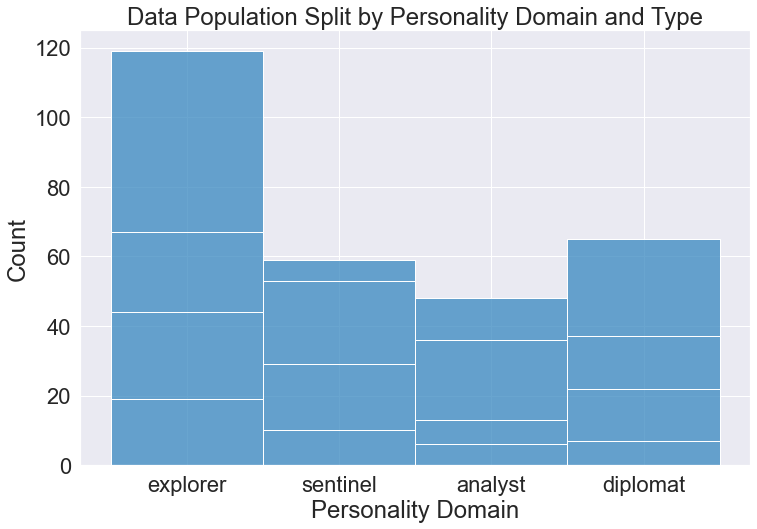

In [8]:
# show the overall visualization
explore.overall_data_vis(train)

### Question 1: What scale of groupings shows a significant relationship in sentiment? Pairs, types, or domains?

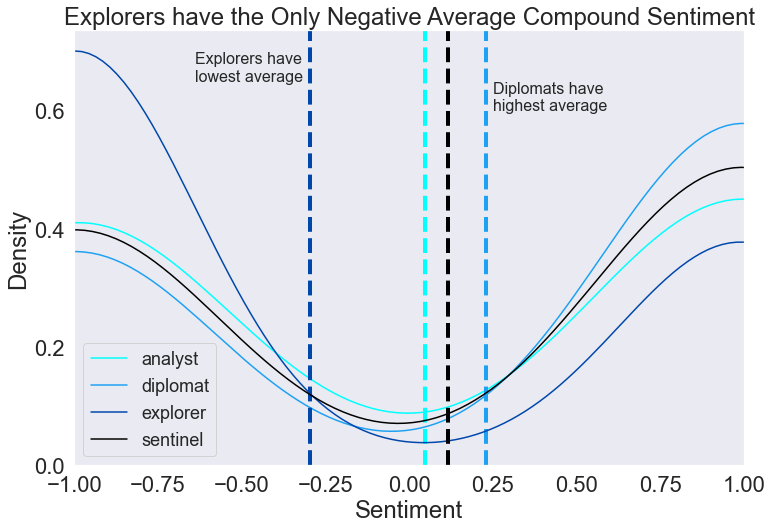

In [9]:
# show the viz for q1
explore.q1_vis(train)

#### Hypothesis 1:

    Ho -> The mean sentiment for explorers is less than or equal to the mean sentiment for analysts
    Ha -> The mean sentiment for explorers is greater than the mean sentiment for analysts
    T-Test, Two-Sample, One-Tailed

In [10]:
# show the stats results for q1
explore.q1_stats(train)


        Fail to Reject the Null Hypothesis.
        Findings suggest there is less than or equal mean sentiment between diplomats and explorers.
        


### Question 1 Takeaways
- Even though there is variance in the mean sentiment between domains, there is not a significant difference

---
### Question 2a: What words are seen across all personality types?

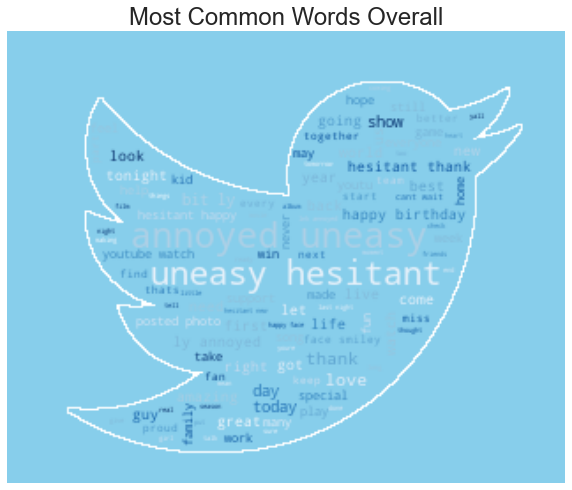

In [11]:
# show the viz for q2a
explore.q2a_vis(train)

### Question 2b: What words are unique by domain?

<img src='capstoneDomains.png' alt='domains' width='500'/>

### Question 2 Takeaways
- Despite the most common words being easy to capture, it is what makes the domains different that will be impactful.

---
### Question 3: Is there a relationship between word count and personality type?

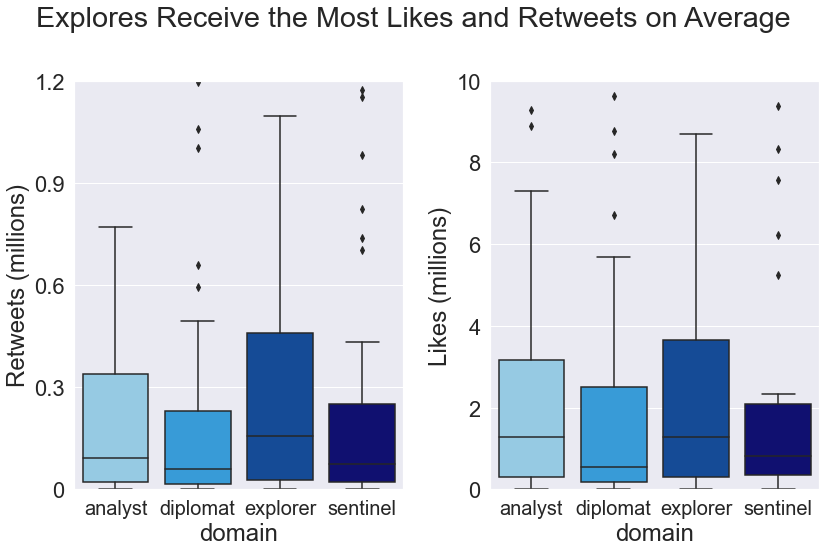

In [12]:
# show the viz for q3
explore.q3_vis(train)

### Question 3 Takeaways
 - Explorers reached the largest audience
 - It makes sense explorers also had the most likes after getting the most retweets

---
## Data Modeling
The goal is to maximize accuracy.

| Features Dropped | Features Kept |
| ---- | ---- |
| pairs | lemmatized |
| domain | bow |
| sentiment | TF-IDF |
| message_length |  |
| word_count |  |
|  |  |

In [14]:
# get the baseline accuracy
model.get_baseline(df)

'Baseline Accuracy: 46.69'

In [15]:
df.head()

,type,personality_domain,I_E,N_S,T_F,J_P,lemmatized,personality_domain_encoded
0,infj,Diplomat,i,n,f,j,httpwwwyoutubecomwatchvqsxhcwekrwhttpmediatumb...,1
1,entp,Analyst,e,n,t,p,finding lack post alarmingsex boring position ...,0
2,intp,Analyst,i,n,t,p,httpswwwyoutubecomwatchvfhigbolffgwof course t...,0
3,intj,Analyst,i,n,t,j,dear intp enjoyed conversation day esoteric ga...,0
4,entj,Analyst,e,n,t,j,youre firedthats another silly misconception a...,0


In [16]:
# get the model results on train and validate
model.top_3_personality_domains(df)

Top Model per Feature
-------------
Bag of Words Logistic Regression Train Accuracy: 99.95%
-------------
Bag of Words Logistic Regression Validate Accuracy: 73.64%
-------------
XBG TF-IDF Personality Domain Train Accuracy: 100.0 %
-------------
XBG TF-IDF Personality Domain Validate Accuracy: 75.82 %
-------------


Top Clustering Model
-------------
Cluster MultinomialNB Train Accuracy: 51.26%
-------------
Cluster MultinomialNB Validate Accuracy: 40.88%
-------------


In [17]:
# get the best model's results on test
model.personality_domain_test(df)

-------------
XBG TF-IDF Personality Domain Test Accuracy: 73.53 %
-------------


### Modeling Takeaways:
- The best model was the TF-IDF XGradientBoosting model at 73.5% accuracy on test.
- The other models showed strong signs of overfitting the data on train, but were producing similar results on validate.

---
## Conclusion
We can accurately use tweets to analyze behavior and classify authors of text into a Myers Briggs domain, which can provide guidance when managers are assigning teams and roles. Our best model performed at 73.5% accuracy vs baseline's 46.7%. 

### Recommendations
 - Exercise this model as a tool in a toolbox, not a guideline heuristic
 - Use this model to create another layer in building diverse teams

### Next Steps:
- Explore further associations in the words to inlcude emojis, swear words, ect. 
- Investigate other social networks and classification methods
---